<a href="https://colab.research.google.com/github/kimsojeong1225/DeepLearning/blob/master/%EC%82%AC%EC%A0%84_%ED%9B%88%EB%A0%A8%EB%90%9C_%EC%BB%A8%EB%B8%8C%EB%84%B7_%EC%82%AC%EC%9A%A9%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow.keras
keras.__version__

NameError: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
cd drive

/content/drive


In [0]:
cd My\ Drive

/content/drive/My Drive


In [0]:
cd cats_and_dogs_small/

/content/drive/My Drive/cats_and_dogs_small


In [0]:
train_cats_dir='./train/cats'
train_dogs_dir='./train/dogs'
validation_cats_dir='./validation/cats'
validation_dogs_dir='./validation/dogs'
test_cats_dir='./test/cats'
test_dogs_dir='./test/dogs'
train_dir='./train'
validation_dir='./validation'
test_dir='./test'
base_dir='./'

In [0]:
from keras.applications import VGG16
# weights : 모델을 초기화할 가중치 체크포인트 지정
#include_top : 네트워크의 최상위 완전 연결 분류기를 포함할지 안 할지
#input_shape : 값 지정을 안해줄 시 네트워크가 어떤 크기의 입력도 처리 가능 
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


58892288/58889256 [==============================] - 5s 0us/step








In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

##### 첫번째 방법
##### 1.출력을 넘파이 배열로 디스크에 저장
##### 2.데이터를 완전 연결 분류기에 입력
##### 3.합성곱 기반 층을 한 번만 실행 -> 빠르고 저렴
#####   데이터 증식 사용 x

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
# ImageDataGenerator : 이미지와 레이블을 넘파이 배열로 추출
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    # predict 메서드 : 이미지에서 특성 추출
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [0]:
from keras import models
from keras import layers
from keras import optimizers
# 규제를 위해 드롭아웃 사용
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))



Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6195 - acc: 0.6560 - val_loss: 0.4289 - val_acc: 0.8420
Epoch 2/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.4264 - acc: 0.8060 - val_loss: 0.3482 - val_acc: 0.8700
Epoch 3/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3596 - acc: 0.8460 - val_loss: 0.3211 - val_acc: 0.8690
Epoch 4/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3170 - acc: 0.8695 - val_loss: 0.3024 - val_acc: 0.8750
Epoch 5/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2910 - acc: 0.8795 - val_loss: 0.2765 - val_acc: 0.8910
Epoch 6/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2586 - acc: 0.8960 - val_loss: 0.2775 - val_acc: 0.8870
Epoch 7/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2444 - acc: 0.9045 - val_loss: 0.2711 - val_acc: 0.8860
Epoch 8/30
2

In [0]:
import matplotlib.pyplot as plt

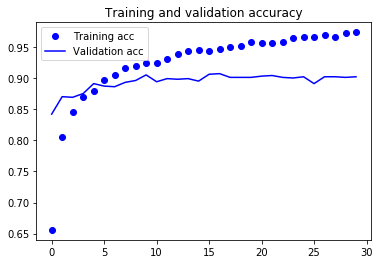

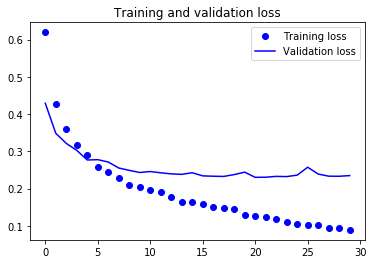

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##### 두번째 방법
##### 1.준비한 모델(conv_base)위에 Dense층 쌓아 확장
##### 2.end-to-end로 전체 모델 실행
##### 3.모든 입력 이미지가 매번 합성곱 기반 층 통과
#####   데이터 증식 사용 o 

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### 동결
##### : 훈련하는 동안 가중치가 업데이트되지 않도록 막음
#####   (합성곱 기반 층에 의해 사전에 학습된 표현이 훈련하는 동안 수정될 수 있음)
##### trainable = False -> 동결

In [0]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [0]:
# cnrkgks 2rodml Dense 층 가중치만 훈련
conv_base.trainable = False

In [0]:
#층마다 2개씩 ( 가중치 행렬, 편향 벡터) 4개의 텐서 훈련
# 편향 : 필터마다 1개씩 
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
 - 450s - loss: 0.5397 - acc: 0.7405 - val_loss: 0.4046 - val_acc: 0.8420
Epoch 2/10
 - 449s - loss: 0.4053 - acc: 0.8270 - val_loss: 0.3475 - val_acc: 0.8520
Epoch 3/10
 - 447s - loss: 0.3481 - acc: 0.8560 - val_loss: 0.2963 - val_acc: 0.8940
Epoch 4/10
 - 447s - loss: 0.3169 - acc: 0.8695 - val_loss: 0.2779 - val_acc: 0.8940
Epoch 5/10
 - 448s - loss: 0.3077 - acc: 0.8685 - val_loss: 0.2675 - val_acc: 0.8960
Epoch 6/10
 - 447s - loss: 0.2820 - acc: 0.8825 - val_loss: 0.2579 - val_acc: 0.9010
Epoch 7/10
 - 447s - loss: 0.2605 - acc: 0.8965 - val_loss: 0.2664 - val_acc: 0.8870
Epoch 8/10
 - 446s - loss: 0.2583 - acc: 0.8990 - val_loss: 0.2466 - val_acc: 0.9020
Epoch 9/10
 - 446s - loss: 0.2544 - acc: 0.8945 - val_loss: 0.2432 - val_acc: 0.9070
Epoch 10/10
 - 445s - loss: 0.2496 - acc: 0.8995 - val_loss: 0.2443 - val_acc: 0.9010


In [0]:
model.save('cats_and_dogs_small_3.h5')

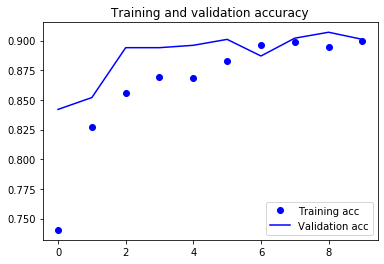

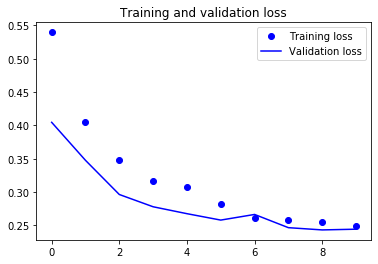

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 5.3.2 미세 조정

In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#### 4번째. 기반 네트워크에서 일부 층의 동결 해제 시행

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

NameError: ignored

In [0]:
# 미세 조정 하는 3개의 층에서 학습된 표현을 조금씩 수정하기위해 RMSprop 학습률 낮춤
#=>기반 모델이 학습된 표현이 많이 바뀔 수 있으므로
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/10
100/100 [==============================] - 528s 5s/step - loss: 0.2478 - acc: 0.9005 - val_loss: 0.2082 - val_acc: 0.9120
Epoch 2/10
100/100 [==============================] - 525s 5s/step - loss: 0.1883 - acc: 0.9280 - val_loss: 0.2046 - val_acc: 0.9190
Epoch 3/10
100/100 [==============================] - 525s 5s/step - loss: 0.1717 - acc: 0.9315 - val_loss: 0.2103 - val_acc: 0.9140
Epoch 4/10
100/100 [==============================] - 525s 5s/step - loss: 0.1608 - acc: 0.9350 - val_loss: 0.2222 - val_acc: 0.9120
Epoch 5/10
100/100 [==============================] - 525s 5s/step - loss: 0.1299 - acc: 0.9480 - val_loss: 0.2053 - val_acc: 0.9200
Epoch 6/10
100/100 [==============================] - 524s 5s/step - loss: 0.1160 - acc: 0.9520 - val_loss: 0.2172 - val_acc: 0.9150
Epoch 7/10
100/100 [==============================] - 525s 5s/step - loss: 0.1099 - acc: 0.9575 - val_loss: 0.2092 - val_acc: 0.9190
Epoch 8/10
100/100 [==============================] - 524s 5s/step - 

In [0]:
model.save('cats_and_dogs_small_4.h5')

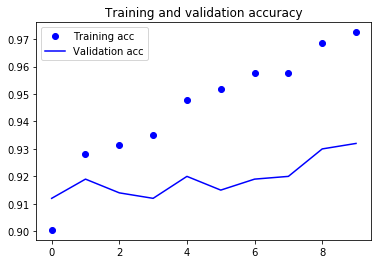

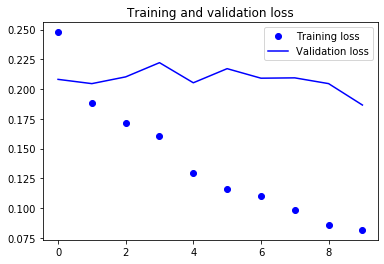

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

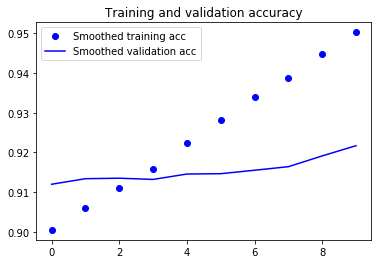

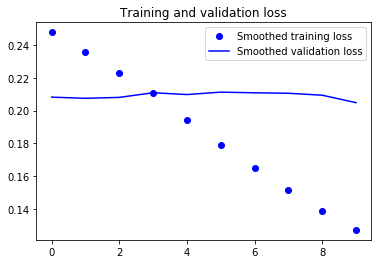

In [0]:
# 정확도와 손실 값을 부드럽게 표현하기 위해 >지수 이동 평균< 이용
# 지수 이동 평균 : 최근에 높은 가중치에 W, 과거(과거 이동 평균)에도 낮은 가중치 1-W 줌 
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9279999947547912


##### 손실 곡선은 악화되었고 정확도는 안정/향상
##### 그래프는 개별적인 손실 값의 평균
##### 정확도에 영향을 미치는 것은 손실 값의 분포 , 평균이 아님
#### 정확도는 모델이 예측한 클래스의 확률이 어떤 임계 값을 넘었는지에대한 결과이기 때문